In [667]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from pyramid.arima import auto_arima

In [668]:
crawldata_colnames=['date', 'crawled_pages'] 
linkdata_colnames= ['links','date'] 
cd = pd.read_csv("crawl.csv",sep='\s',parse_dates=['date'], index_col='date', usecols=[*range(0,2)], names=crawldata_colnames, skiprows=1,header=None)
gad = pd.read_csv("google_analytics_data.csv", parse_dates=['ga:date'], index_col='ga:date')
ld = pd.read_csv("links.csv", parse_dates=['date'], index_col='date',names=linkdata_colnames,skiprows=1,header=None)

/home/aa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [669]:
pa= gad.loc[gad['ga:sourceMedium'] == 'google / organic'].groupby(['ga:date']).count()['ga:pagePath']

In [670]:
pa = pa.reset_index()
pa.columns = ['date','active_pages']
pa.set_index('date',inplace=True)

In [671]:
ld = ld.groupby(['date']).count()['links']

In [672]:
df = pd.concat([cd, pa, ld], axis=1)

In [673]:
df = df.fillna(0)

In [674]:
dfm =  df.resample('M').sum()
dfm =  dfm[(dfm!= 0).all(axis=1)]

In [687]:
dfm.index

DatetimeIndex(['2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30'],
              dtype='datetime64[ns]', name='date', freq='M')

In [675]:
scaler = StandardScaler()
dfm[['crawled_pages','active_pages','links']] = scaler.fit_transform(dfm[['crawled_pages','active_pages','links']])

In [710]:
dftrain = dfm.loc['2016-09-30':'2018-08-31',]
dftest = dfm.loc['2018-09-30':'2018-09-30',]
test_pa = dftest['active_pages']
y = np.array(dftrain['active_pages'])
exogenous = np.array(dftrain[['crawled_pages','links']])
pa_fit_exo = auto_arima(y=y, exogenous=exogenous, start_p=0, start_q=0, max_p=3, max_q=3,
                    start_P=0, seasonal=False, d=1, D=0, trace=True,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=True)
pa_fit_exo.summary()

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

Fit ARIMA: order=(0, 1, 0); AIC=88.654, BIC=93.196, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0); AIC=89.012, BIC=94.690, Fit time=0.100 seconds
Fit ARIMA: order=(0, 1, 1); AIC=77.372, BIC=83.050, Fit time=0.115 seconds
Fit ARIMA: order=(1, 1, 1); AIC=79.368, BIC=86.181, Fit time=0.200 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=81.373, BIC=89.321, Fit time=0.545 seconds
Total fit time: 0.985 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   23
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -33.686
Method:                       css-mle   S.D. of innovations              0.977
Date:                Mon, 22 Oct 2018   AIC                             77.372
Time:                        13:20:32   BIC                             83.050
Sample:                             1   HQIC                            78.800
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0514      0.045      1.150      0.265      -0.036       0.139
x1            -0.0598      0.144     -0.414      0.683      -0.343       0.223
x2             0.0210      0.171      0.123      0.904      -0.314       0.356
ma.L1.D.y     -1.0000      0.114     -8.739      0.000      -1.224      -0.776
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [711]:
pa_future_forecast = pa_fit_exo.predict(n_periods=len(dftest.index), exogenous = np.array(dftest[['crawled_pages','links']]))

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


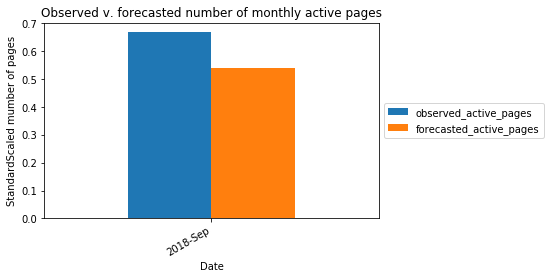

In [712]:
pa_df = pd.DataFrame(pa_future_forecast, index = dftest.index)
observed_v_forecasted= pd.concat([dftest.active_pages,pa_df],axis=1)
observed_v_forecasted_colnames = ['observed_active_pages','forecasted_active_pages']
observed_v_forecasted.columns = observed_v_forecasted_colnames
observed_v_forecasted.index = observed_v_forecasted.index.strftime('%Y-%b')
observed_v_forecasted.plot.bar()
L = plt.legend()
L.get_texts()[0].set_text('ObservedAP')
L.get_texts()[1].set_text('ForecastedAP')
plt.gcf().autofmt_xdate()
plt.ylabel('StandardScaled mumber of pages', fontsize=10)
plt.xlabel('Date',fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Observed v. forecasted number of monthly active pages')
plt.show()

In [713]:
mae = mean_absolute_error(test_pa, pa_future_forecast)
print('MAE: %f' % mae)
mse = mean_squared_error(test_pa, pa_future_forecast)
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.130768
MSE: 0.017100
RMSE: 0.130768


In [686]:
scaled_active_pages_inverse = scaler.inverse_transform(np.column_stack( (pa_future_forecast,np.array(dftest[['crawled_pages','links']])) ))[:, [0]]